# Conditional Choice Probability Estimators in 5 Easy Steps!

## Author: Eric Schulman

The following guide demonstrates how to use conditional choice probability (CCP) estimators in Python. It was written in part as a homework for the University of Texas second year course in industrial organization. These estimators are the normal way to think about how the future influences decisions in industrial organization and related economic fields.

To demonstrate how to use (and implement) a CCP estimator, we recover parameters for the cost function in [Rust 1987](https://www.jstor.org/stable/1911259). Rust's paper considers the decision of a bus manager. The bus manager decides whether or not to replace bus engines for his fleet of buses in Madison, Wisconsin. Replacing the engine has a high cost in the present but letting the engine accumulate mileage makes the bus more likely to break down in the future. Our goal is estimating parameters that tell us the importance of mileage when the bus manager decides to replace the engines. The bus manager's problem is very general and has become the 'mascot' for dynamic decisions in industrial organization.

We could use a logit to predict the bus manager's decisions. However, Rust found that a model where agents considered the future predicts bus engine replacement decisions more accurately. To think about the future, Rust simplified the bus manager's problem as a Markov decision process. In a Markov decision process, the bus manager only needs to consider how his decisions affect the bus' mileage next period. The bus manager controls the bus' mileage $x$ through $i$, a variable that determines whether he replaces the bus engine. He experiences unobserved costs $\epsilon$ each period. Given the bus manger's payoffs each period, $u(i,x, \epsilon ; \theta)$, we can write the bus manager's decision as a dynamic program. Rust calculated this value function inside a logit. Rust has code for solving this value function and estimate parameters in Gauss on his [website](https://editorialexpress.com/jrust/nfxp.html).


$$V(x) = \text{max}_{i} u(i,x, \epsilon; \theta) +  \beta E[V(x') | x, i]$$


The more popular approach to predicting dynamic choices is called conditional choice probability (CCP) estimation. This approach works similar to Rust's asymptotically. However, it simplifies Rust's algorithm. Instead of embedding a value function into a logit, we start with a simple estimate of the choice probabilities and adjust this estimate to account for the future. Our initial estimate of the choice probabilities will help us calculate the value function to adjust the estimates of how mileage influences the replacement probability. This approach was first introduced to the literature in [Hotz Miller 1993](https://www.jstor.org/stable/2298122). The code and data in this guide from comes from Victor Aguirregabiria and Pedro Mira's [website](http://individual.utoronto.ca/vaguirre/wpapers/program_code_survey_joe_2008.html) accompanying their paper [Aguirregabiria Mira 2002](http://individual.utoronto.ca/vaguirre/wpapers/program_code_survey_joe_2008.html) (more on them later).



In [17]:
import pandas as pd
import math
import numpy as np
import statsmodels.api as sm
import matplotlib.pyplot as plt

from scipy.interpolate import interp1d #pre written interpolation function
from statsmodels.base.model import GenericLikelihoodModel
from scipy import stats #for kernel function

## Step 1: Setup data and constants

First, we must load the data into memory and pick a discount factor. The discount factor is the most important aspect of the CCP estimator and distinguishes it from a logit. Implicitly, our choice is an assumption about the bus manager because nothing in the data tells us about agent's discount factor (for more about this see [Magnac Thesmar 2002](https://www.jstor.org/stable/2692293)). All we see are mileage and replacement decisions.

In [18]:
#constants/data set up
BETA = .9999
GAMMA = .5772 #euler's constant

#format the bus .dat from augirregabiria and mira's website
data = np.fromfile('bus1234.dat')
data = data.reshape(len(data)/6,6)
data = pd.DataFrame(data,columns=['id','group','year','month','replace','miles'])

#save to .csv
data.to_csv('bus1234.csv')

#divide by 1e6 (use the same scale are Rust and AM)
data['miles'] = (data['miles'])/1e6

#switch to date time for ease 
data['date'] = pd.to_datetime(data[['year', 'month']].assign(Day=1))
data = data[['id','group','date','replace','miles']]

#lag date
date_lag = data.copy()
date_lag['date'] = date_lag['date'] - pd.DateOffset(months=1)
data = data.merge(date_lag, how='left', on=['id','group','date'] , suffixes=('','_next'))
data = data.dropna()

## Step 2: Setup the transition matrices

The bus managers problem is dynamic. The bus' mileage $x$ will increase no matter what the bus manager does. We need to learn how the state will evolve. To make the problem easier, Rust thought about the bus manager's problem in terms of a discrete number of state variables.  With $K$ discrete states, we can think about the probability of the next state $x'$ given $x$ as a $K \times K$ matrix. The rows of the matrix refer to the current state $x$ and the columns are $x'$.

### Discretizing the state variable
First we discretize our continuous data on mileage into $K$ states to caclulate the value function for a given amount of mileage more easily. 

In [19]:
#size of step in discretization
STEP = .002

#make states global variables
STATES = np.arange(data['miles'].min(),data['miles'].max() + STEP, STEP)

### Transition probabilities
Then we estimate $\pi_k$, the probability of 'jumping' $k$ states. For example, $\pi_1$ is might be the probability that $x$ increases by 1 state next period. We will learn $\pi_k$ using the Gaussian kernel. 

In [20]:
def miles_pdf(i_obs, x_obs, x_next):
    """estimation of mileage pdf following AM using the
    kernel function
    
    this corresponds to pdfdx in AM's code"""
    
    #figure out max number of steps
    dx = (1-i_obs)*(x_next - x_obs) + i_obs*x_next
    
    #number of 'transition' states
    dx_states = np.arange(dx.min(),dx.max() +STEP , STEP)
    
    #use kernel groups to make pdf
    kernel1 = stats.gaussian_kde(dx, bw_method='silverman')
    pdfdx = kernel1(dx_states)
    
    return np.array([pdfdx/pdfdx.sum()]).transpose()


MILES_PDF = miles_pdf(data['replace'], data['miles'], data['miles_next'])

### Graphing transition probabilities

To make this more concrete, we graph these probabilities below. We can the state is most likely to increase by roughly 2000 miles.

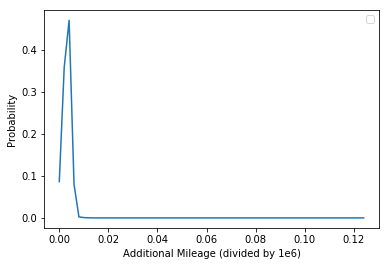

In [23]:
#set up plot of both value functions
fig = plt.figure()

#make a plot of both value functions
plt.ylabel('Probability')
plt.xlabel('Additional Mileage (divided by 1e6)')
plt.plot(STATES[0:len(MILES_PDF)],MILES_PDF)

plt.legend()

### Transition matrices
With the transition probabilities we can write two matrices that tell us how each bus's mileage $x$ will change depending on the engine replacement decision $i$. Let $F(i)$ be the transition matrix between states depending on the replacement decision $i$. As an example, if $\pi_k$ is the probability of transitioning $k$ states

$$F(1) = \begin{bmatrix} 
\pi_0 & \pi_1 & \pi_2 & ... & 0 \\
\pi_0 & \pi_1 & \pi_2 & ... & 0 \\
... & ... & ... & ... & ... \\
\end{bmatrix}$$
 
$$F(0) = \begin{bmatrix} 
\pi_0 & \pi_1 & \pi_2 & ... & 0 \\ 
0 & \pi_0 & \pi_1 & ... & 0 \\
... & ... & ... & ... & ... \\ \end{bmatrix}$$

I implemented $F(1)$ first because it reverts every state back to state 0 and is easier to think about.

In [6]:
def transition_1(i_obs, x_obs , x_next):
    """calculate transitions probabilities,
    non-parametrically
    
    this corresponds to fmat2 in AM's code"""
    
    #transitions when i=1
    pdfdx = miles_pdf(i_obs, x_obs, x_next).transpose()
    
    #zero probability of transitioning to large states
    zeros = np.zeros( (len(STATES),len(STATES)-pdfdx.shape[1]) )
    
    #transitioning to first state and 'jumping' dx states
    fmat1 = np.tile(pdfdx,(len(STATES),1))
    fmat1 = np.concatenate( (fmat1, zeros), axis=1 )

    return fmat1

FMAT1 = transition_1(data['replace'], data['miles'],data['miles_next'])

In [7]:
def transition_0(i_obs, x_obs, x_next):
    """calculate transitions probabilities,
    non-parametrically
    
    this corresponds to fmat1 in AM's code"""
    
    pdfdx = miles_pdf(i_obs, x_obs, x_next).transpose()
    
    #initialize fmat array, transitions when i=0
    end_zeros = np.zeros((1, len(STATES) - pdfdx.shape[1]))
    fmat0 = np.concatenate( (pdfdx, end_zeros), axis=1 )

    for row in range(1, len(STATES)):
        
        #this corresponds to colz i think
        cutoff = ( len(STATES) - row - pdfdx.shape[1] )
        
        #case 1 far enough from the 'end' of the matrix
        if cutoff >= 0:
            start_zeros = np.zeros((1,row))
            end_zeros = np.zeros((1, len(STATES) - pdfdx.shape[1] - row))
            fmat_new = np.concatenate( (start_zeros, pdfdx, end_zeros), axis=1 )
            fmat0 = np.concatenate((fmat0, fmat_new))
       
        #case 2, too far from the end and need to adjust probs
        else:
            pdf_adj = pdfdx[:,0:cutoff]
            pdf_adj = pdf_adj/pdf_adj.sum(axis=1)
            
            start_zeros = np.zeros((1,row))
            fmat_new = np.concatenate( (start_zeros, pdf_adj), axis=1 )
            fmat0 = np.concatenate((fmat0, fmat_new))
            
    return fmat0

FMAT0 = transition_0(data['replace'],data['miles'],data['miles_next'])

PR_TRANS = FMAT0, FMAT1

## Step 2: Calculate the value the function

With the transition matrices, we can calculate the value function for our maximum likelihood estimation. Taking the value function into account predicts the bus manager's decision more accurately. We need to be careful though. The bus manager may make different decisions about two buses with the same mileage.  We include an unobserved costs $\epsilon$ to ensure the model is theoretically consistent with the data. If our model fit the data poorly, this would mean that the bus manager has high 'unobserved' costs.

To make the unobserved costs analytically tractable, we usually make 2 important assumptions about them

1. That the shock $\epsilon$ follows an extreme value distribution. Why? To calculate the probability of replacing the engine we must compare $\epsilon_{1}$ to the other possible shock $\epsilon_{0}$. By focusing on extreme values, we only need to think about the likelihood of one shock i.e. the most extreme.

2. We also assume thse shocks effect decisions like random noise (conditional independence).  In other words, the shocks do not systematically influence the mileage.

$$p(x', \epsilon |x) = p(x'|x)p(\epsilon)$$


### Initial conditional choice probabilities

Our approach to calculating the value function diverges from Rust's original methods. Rust's approach for calculating the value function involves repeatedly applying the Bellman operator to find its fixed point. This becomes time consuming when nested inside a maximum likelihood routine. Our method will be quicker and still fits the data more accurately than a regular logit. We start by using a logit to predict the probability of engine replacement decision $i$ conditional on mileage $x$.

Our result will be a $K \times 1$ vector with the probability of replacing the engine conditional on the mileage $x$. We will learn this vector, $P$, using a logit just like Aguirregabiria and Mira. We will use these choice probabilities to calculate the value function without repeatedly iterating. In principle, we could experiment with other consistent methods.

In [8]:
def initial_pr(i_obs, x_obs, d=0):
    """initial the probability of view a given state following AM.
    just involves logit to predict
    
    Third arguement involves display"""
    
    X = np.array([x_obs, x_obs**2, x_obs**3]).transpose()
    X = sm.add_constant(X)
    
    model = sm.Logit(i_obs,X)
    fit = model.fit(disp=d)
    if d: print(fit.summary())
    
    x_states = np.array([STATES, STATES**2, STATES**3]).transpose()
    x_states = sm.add_constant(x_states)
    
    return fit.predict(x_states)

PR_OBS = initial_pr(data['replace'], data['miles'], d=1)

Optimization terminated successfully.
         Current function value: 0.036201
         Iterations 23
                           Logit Regression Results                           
Dep. Variable:                replace   No. Observations:                 8156
Model:                          Logit   Df Residuals:                     8152
Method:                           MLE   Df Model:                            3
Date:                Mon, 21 Jan 2019   Pseudo R-squ.:                  0.1671
Time:                        16:11:37   Log-Likelihood:                -295.26
converged:                       True   LL-Null:                       -354.51
                                        LLR p-value:                 1.623e-25
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const        -17.3136      4.188     -4.134      0.000     -25.522      -9.105
x1           149.3089     56

### Hotz Miller's 'alternative' value function calculation

Using the payoff function (whose parameters we want to learn), the transition matrices, and the initial choice probabilities (which we estimated) we can now calculate the bus manager's value function following Aguirregabiria and Mira's Gauss code and paper using the following formula. 

$$V(x) = [I_m - \beta( (1-P) * F(0) +  P * F(1)) ]^{-1} [(1-P)*(u(0,x;\theta) + \gamma -ln(1-P)) + P*( u(1,x;\theta) + \gamma -ln(P) ) ]$$

Hotz Miller derived this formula in their paper. This corresponds to equation (8) in Aguirregabiria Mira 2002.

For the purposes of clarifying the formula to see how I implemented it.
* $*$ is the Hadamard produce (i.e. element wise).
* $u(i,x;\theta)$ is the payoff function. I implemented this function using a Python `lambda` expression so that the cost specification is flexible. This means that the routine for calculating the value function takes the cost function (and its parameters) as an argument. Generally speaking it has the form.

* Finally, note there is a slight abuse of notation going on. The dimensions of $F$ are $K \times K$ so I needed to tile the vector $P$ in order to take the element wise product.

In [9]:
def hm_value(params, cost, pr_obs, pr_trans):
    """calculate value function using hotz miller approach"""
    
    #set up matrices, transition is deterministic
    trans0, trans1 = pr_trans
    
    #calculate value function for all state
    pr_tile = np.tile( pr_obs.reshape( len(STATES) ,1), (1, len(STATES) ))
    
    denom = (np.identity( len(STATES) ) - BETA*(1-pr_tile)*trans0 - BETA*pr_tile*trans1)
    
    numer = ( (1-pr_obs)*(cost(params, STATES, 0) + GAMMA - np.log(1-pr_obs)) + 
                 pr_obs*(cost(params, STATES, 1) + GAMMA - np.log(pr_obs) ) )
    
    value = np.linalg.inv(denom).dot(numer)
    return value

## Step 3: (Psuedo) Maximum likelihood estimation

With the value function we just calculated, we can adjust the likelihood of replacing the engine at mileage $x$ with the following formula. It is very similar to the logit we used before and produces a $K\times1$ vector with a probability of replacement in each state. Now, the replacement probability also depends on $\beta$ and future $x$'s. 

$$\psi(P ; \theta) = \dfrac{exp[u(1,x,\theta) + \beta F(1) V] }{exp[u(1,x,\theta) + \beta F(1) V] + exp[u(0,x,\theta) + \beta F(0) V] }$$ 

This corresponds to the $\Psi$ function in Aguirregabiria Mira 2002. They parametrize $\Psi$ using the extreme value distribution right below Proposition 3 in their paper.

Ultimately, we wanted to learn how mileage influences the bus manager's decision by estimating the parameters in the cost function $\theta$. To learn these parameters, we can maximize the value of this likelihood $\psi$ 'adjusted' for the  value function we estimated. This differs from regular maximum likelihood estimation. This approach 'cheated' by estimating the value function ahead of time to make the routine run faster. By cheating we loose precision (efficiency) in our estimates. 

In [10]:
def hm_prob(params, cost, pr_obs, pr_trans):
    """calculate psi (i.e. CCP likelihood) using 
    the value function from the hotz miller appraoch"""
    
    value = hm_value(params, cost, pr_obs, pr_trans)
    value = value - value.min() #subtract out smallest value
    trans0, trans1 = pr_trans
    
    delta1 = np.exp( cost(params, STATES, 1) + BETA*trans1.dot(value))
    delta0 = np.exp( cost(params, STATES, 0) + BETA*trans0.dot(value) )
    
    return delta1/(delta1+delta0)

In [11]:
class CCP(GenericLikelihoodModel):
    """class for estimating the values of R and theta
    using the CCP routine and the helper functions
    above"""
    
    def __init__(self, i, x, x_next, params, cost, **kwds):
        """initialize the class
        
        i - replacement decisions
        x - miles
        x_next - next periods miles
        params - names for cost function parameters
        cost - cost function specification, takes agruements (params, x, i) """
        
        super(CCP, self).__init__(i, x, **kwds)
        
        #data
        self.endog = i #these names don't work exactly
        self.exog = x #the idea is that x is mean indep of epsilon
        self.x_next = x_next
        
        #transitions
        self.pr_obs = initial_pr(i, x)
        self.trans =  transition_0(i,x,x_next), transition_1(i,x,x_next)
        
        #should probably make these class parameters
        self.num_states = ( x.max()/STEP).astype(int) + 2
        self.states = np.arange(x.min(),x.max() + STEP, STEP)
        
        #initial model fit
        self.cost = cost
        self.num_params = len(params)
        self.data.xnames =  params
        self.results = self.fit( start_params=np.ones(self.num_params) )
        
        
    def nloglikeobs(self, params, v=False):
        """psuedo log likelihood function for the CCP estimator"""
        
        # Input our data into the model
        i = self.endog
        x = (self.exog/STEP).astype(int)*STEP #discretized x
           
        #set up hm state pr
        prob = hm_prob(params, self.cost, self.pr_obs, self.trans).transpose()
        prob = interp1d(self.states, prob)
        prob = prob(x)
        
        log_likelihood = (1-i)*np.log(1-prob) + i*np.log(prob)
        
        return -log_likelihood.sum()
    
    
    def iterate(self, numiter):
        """iterate the Hotz Miller estimation procedure 'numiter' times"""
        i = 0
        while(i < numiter):
            #update pr_obs based on parameters
            self.pr_obs = hm_prob(self.results.params, self.cost, self.pr_obs, self.trans)
            
            #refit the model
            self.results = self.fit(start_params=np.ones(self.num_params))
            i = i +1

### Linear Costs

First we estimate the cost of additional mileage and the cost of replacing a new engine using a linear cost function specification. This means that the cost associated with driving a bus is directly proportional to its mileage. 

$$u(i,x;\theta) = (1-i)(\theta_1 x) + i(RC) $$

Aguirregabiria and Mira found the 'true' maximum likelihood estimates for these parameters in their paper by iteratively calculating the value function. I included these estimates below for reference. Our CCP estimator preforms relatively well in comparison. 

|Parameter| MLE Estimate |
|--|--|
| $\theta_1$|-.58 |
|$RC$| -10.47|


In [12]:
#define cost functon using lambda expression
linear_cost = lambda params, x, i: (1-i)*x*params[i] + i*params[i]

linear_model = CCP(data['replace'], data['miles'], data['miles_next'], ['theta1','RC'], linear_cost)
print(linear_model.results.summary())

Optimization terminated successfully.
         Current function value: 0.036544
         Iterations: 63
         Function evaluations: 120
                                 CCP Results                                  
Dep. Variable:                replace   Log-Likelihood:                -298.05
Model:                            CCP   AIC:                             598.1
Method:            Maximum Likelihood   BIC:                             605.1
Date:                Mon, 21 Jan 2019                                         
Time:                        16:11:40                                         
No. Observations:                8156                                         
Df Residuals:                    8155                                         
Df Model:                           0                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------

### Comparison with the logit

For the sake of comparrison, we graph the choice probabilities predicted by the logit with the CCP estimator. Including the cubic term most likely overfits the data. The probability of replacing is very high for out of sample observations. This may not be realistic.

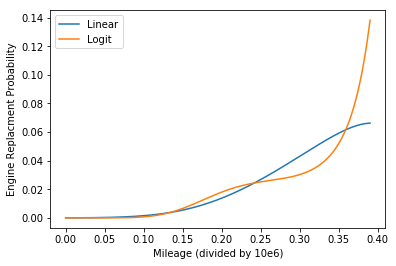

In [25]:
#set up plot of both value functions
fig = plt.figure()
p_linear = hm_prob(linear_model.results.params, linear_model.cost, linear_model.pr_obs, linear_model.trans) 
p_linear = p_linear 

#make a plot of both value functions
plt.ylabel('Engine Replacment Probability')
plt.xlabel('Mileage (divided by 10e6)')
plt.plot(STATES,p_linear,label='Linear')
plt.plot(STATES, PR_OBS, label='Logit')

plt.legend()

### Quadratic costs

Rust wanted to demonstrate that a model where the Bus manager considered the future using a dynamic program fit the data better. As a result, Rust gave many cost function specifications. One additional specification involves quadratic costs.

$$u(i,x;\theta) = (1-i)(\theta_1 x + \theta_2 x^2) + i(RC) $$

In [13]:
quad_cost = lambda params, x, i: (1-i)*(x*params[0] + x**2*params[1]) + i*params[2]

quad_model = CCP(data['replace'], data['miles'], data['miles_next'], ['theta1','theta2', 'R'], quad_cost)
print(quad_model.results.summary())

Optimization terminated successfully.
         Current function value: 0.036261
         Iterations: 147
         Function evaluations: 260
                                 CCP Results                                  
Dep. Variable:                replace   Log-Likelihood:                -295.75
Model:                            CCP   AIC:                             593.5
Method:            Maximum Likelihood   BIC:                             600.5
Date:                Mon, 21 Jan 2019                                         
Time:                        16:11:44                                         
No. Observations:                8156                                         
Df Residuals:                    8155                                         
Df Model:                           0                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------

### Comparing cost functions

When we compare the replacement probabilities under both specifications side by side, we see that the different specification does not drastically change the bus manager's decision at a given mileage. They are much closer than the linear function compared with the logit. Considering the limited data, we probably cannot learn the actual functional form for the cost function.

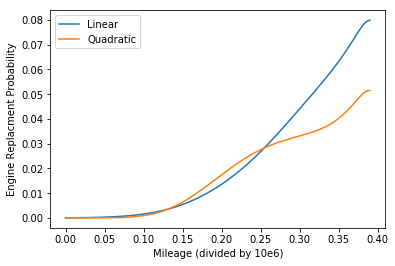

In [14]:
#set up plot of both value functions
fig = plt.figure()
p_quad = hm_prob(quad_model.results.params, quad_model.cost, quad_model.pr_obs, quad_model.trans)
p_quad = p_quad 

#make a plot of both value functions
plt.ylabel('Engine Replacment Probability')
plt.xlabel('Mileage (divided by 10e6)')
plt.plot(STATES,p_linear,label='Linear')
plt.plot(STATES,p_quad, label='Quadratic')

plt.legend()

## Step 5: Iterating the model

Before we calculated $\psi(P;\theta)$ by estimating the probability of replacing the engine using a logit. The key to calculating  $\psi( \cdot ;\theta)$ is $P$. Our approach to estimating $P$ is very simple. So, you may wonder what happens if we use a better starting estimate of the choice probabilities? If we use a more precise $P$, Aguirregabiria and Mira showed that $\psi(P;\theta)$ will be more precise in their 2002 paper! 

Using better starting value like $\psi(P;\hat{\theta})$ guarantees that $\psi( \psi(P;\hat{\theta}); \theta)$ will be more precise. What's more, nothing is stopping you from repeating this process. After calculating $\psi( \psi(P;\hat{\theta}); \theta)$, you can plug your estimate back into $\psi( \cdot ; \theta)$. In fact, if you keep iterating then you will converge to 'true' likelihood function estimates.

To demonstrate how this works, we iterate the CCP estimation procedure by repeatedly plugging the previous estimate of $\psi( \cdot ; \theta)$ into the likelihood function. We can see that the estimates get closer to Aguirregabiria and Mira's 'true' maximum likelihood estimates.

In [15]:
linear_model.iterate(2)
print(linear_model.results.summary())

Optimization terminated successfully.
         Current function value: 0.036530
         Iterations: 62
         Function evaluations: 117
Optimization terminated successfully.
         Current function value: 0.036528
         Iterations: 63
         Function evaluations: 118
                                 CCP Results                                  
Dep. Variable:                replace   Log-Likelihood:                -297.93
Model:                            CCP   AIC:                             597.9
Method:            Maximum Likelihood   BIC:                             604.9
Date:                Mon, 21 Jan 2019                                         
Time:                        16:11:48                                         
No. Observations:                8156                                         
Df Residuals:                    8155                                         
Df Model:                           0                                         
           

## Works Cited

* Aguirregabiria, V., & Mira, P. (2002). Swapping the Nested Fixed Point Algorithm: A Class of Estimators for Discrete Markov Decision Models. Econometrica, 70(4), 1519-1543. Retrieved from http://www.jstor.org/stable/3082006

* Hotz, V., & Miller, R. (1993). Conditional Choice Probabilities and the Estimation of Dynamic Models. The Review of Economic Studies, 60(3), 497-529. Retrieved from http://www.jstor.org/stable/2298122

* Magnac, T., & Thesmar, D. (2002). Identifying Dynamic Discrete Decision Processes. Econometrica, 70(2), 801-816. Retrieved from http://www.jstor.org/stable/2692293

* Rust, J. (1987). Optimal Replacement of GMC Bus Engines: An Empirical Model of Harold Zurcher. Econometrica, 55(5), 999-1033. doi:10.2307/1911259
